In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.image import ssim
from sklearn.model_selection import train_test_split

In [2]:
# Load Fashion MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Normalize and expand dimensions
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


In [4]:
# Train-Validation Split
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

In [5]:
def add_adaptive_noise(images, min_noise=0.2, max_noise=0.5):
    noisy_images = []
    for img in images:
        noise_level = np.random.uniform(min_noise, max_noise)
        noise = noise_level * np.random.normal(0, 1, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

In [6]:
x_train_noisy = add_adaptive_noise(x_train)
x_val_noisy = add_adaptive_noise(x_val)
x_test_noisy = add_adaptive_noise(x_test)

In [7]:
def build_ultra_clear_denoiser():
    inputs = layers.Input(shape=(28, 28, 1))

    # --- ENCODER ---
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x_skip1 = layers.Conv2D(32, 1, padding='same')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.add([x_skip1, x])
    x = layers.MaxPooling2D(2)(x)  # 14x14x32

    x_skip2 = layers.Conv2D(64, 1, padding='same')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.add([x_skip2, x])
    x = layers.MaxPooling2D(2)(x)  # 7x7x64

    # --- BOTTLENECK ---
    bottleneck = x  # save for later visualization
    att = layers.Conv2D(1, 1, activation='sigmoid')(x)
    x = layers.multiply([x, att])

    # --- DECODER ---
    x = layers.UpSampling2D(2)(x)  # 14x14x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)  # 28x28x64
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    def perceptual_loss(y_true, y_pred):
        mse = MeanSquaredError()(y_true, y_pred)
        ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
        return mse + 0.5 * ssim_loss

    model.compile(optimizer=Adam(0.001), loss=perceptual_loss)
    return model, models.Model(inputs, bottleneck)

model, encoder = build_ultra_clear_denoiser()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 14, 14,    │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 7, 7, 1)   │         65 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7, 64)  │          0 │ max_pooling2d_1[… │
│                     │                   │            │ conv2d_7[0][0]  

 Total params: 134,050 (523.63 KB)

 Trainable params: 133,602 (521.88 KB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_denoiser.h5', save_best_only=True)


In [9]:
history = model.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_val_noisy, x_val),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2619

375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 0.2617 - val_loss: 0.2770
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1643

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1643 - val_loss: 0.1565
Epoch 3/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1506

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1506 - val_loss: 0.1483
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1447 - val_loss: 0.1497
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1425 - val_loss: 0.1515
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1404

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1404 - val_loss: 0.1417
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1384 - val_loss: 0.1417
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1367 - val_loss: 0.1424
Epoch 9/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1356

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.1356 - val_loss: 0.1413
Epoch 10/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1347

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.1347 - val_loss: 0.1375
Epoch 11/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1339 - val_loss: 0.1389
Epoch 12/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1325

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.1325 - val_loss: 0.1373
Epoch 13/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.1319 - val_loss: 0.1386
Epoch 14/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1320 - val_loss: 0.1378
Epoch 15/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1317 - val_loss: 0.1382
Epoch 16/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1305

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1305 - val_loss: 0.1362
Epoch 17/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1303 - val_loss: 0.1366
Epoch 18/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1303 - val_loss: 0.1366
Epoch 19/100
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1293

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1293 - val_loss: 0.1355
Epoch 20/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1292 - val_loss: 0.1358
Epoch 21/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1282 - val_loss: 0.1360
Epoch 22/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1280

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1280 - val_loss: 0.1349
Epoch 23/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1279 - val_loss: 0.1357
Epoch 24/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1272

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1272 - val_loss: 0.1348
Epoch 25/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1267

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1267 - val_loss: 0.1340
Epoch 26/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1281 - val_loss: 0.1345
Epoch 27/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1267 - val_loss: 0.1354
Epoch 28/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1263 - val_loss: 0.1354
Epoch 29/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1264 - val_loss: 0.1351
Epoch 30/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1261 - val_loss: 0.1344
Epoch 31/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1256 - val_loss: 0.1345
Epoch 32/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1256 - val_loss: 0.1370
Epoch 33/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1256

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1256 - val_loss: 0.1339
Epoch 34/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1252 - val_loss: 0.1341
Epoch 35/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1249 - val_loss: 0.1355
Epoch 36/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1248 - val_loss: 0.1350
Epoch 37/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1250 - val_loss: 0.1347
Epoch 38/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1238 - val_loss: 0.1350
Epoch 39/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1246 - val_loss: 0.1352
Epoch 40/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1243

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1243 - val_loss: 0.1339
Epoch 41/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1247 - val_loss: 0.1340
Epoch 42/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1237

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1237 - val_loss: 0.1335
Epoch 43/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1238

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1238 - val_loss: 0.1334
Epoch 44/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1239 - val_loss: 0.1342
Epoch 45/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1236 - val_loss: 0.1334
Epoch 46/100
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1235

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1235 - val_loss: 0.1334
Epoch 47/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1227 - val_loss: 0.1335
Epoch 48/100
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1234

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1234 - val_loss: 0.1331
Epoch 49/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1229 - val_loss: 0.1331
Epoch 50/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1221 - val_loss: 0.1342
Epoch 51/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.1230 - val_loss: 0.1340
Epoch 52/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.1225 - val_loss: 0.1344
Epoch 53/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1224 - val_loss: 0.1336
Epoch 54/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1226 - val_loss: 0.1332
Epoch 55/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1225 - val_loss: 0.1342
Epoch 56/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1219 - val_loss: 0.1348
Epoch 57/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1214 - val_loss: 0.1344
Epoch 58/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1226 - val_loss: 0.1346


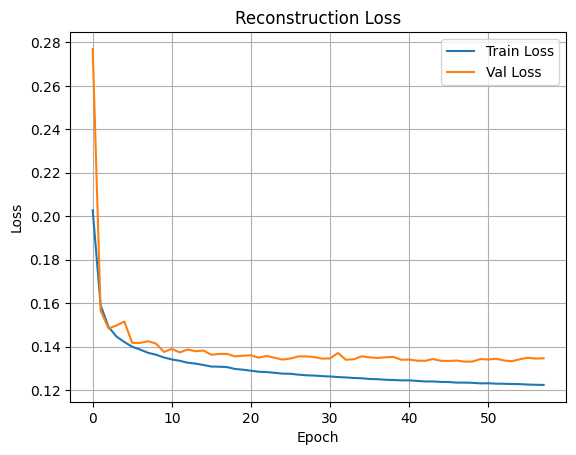

In [10]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Predict on test set
denoised_imgs = model.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


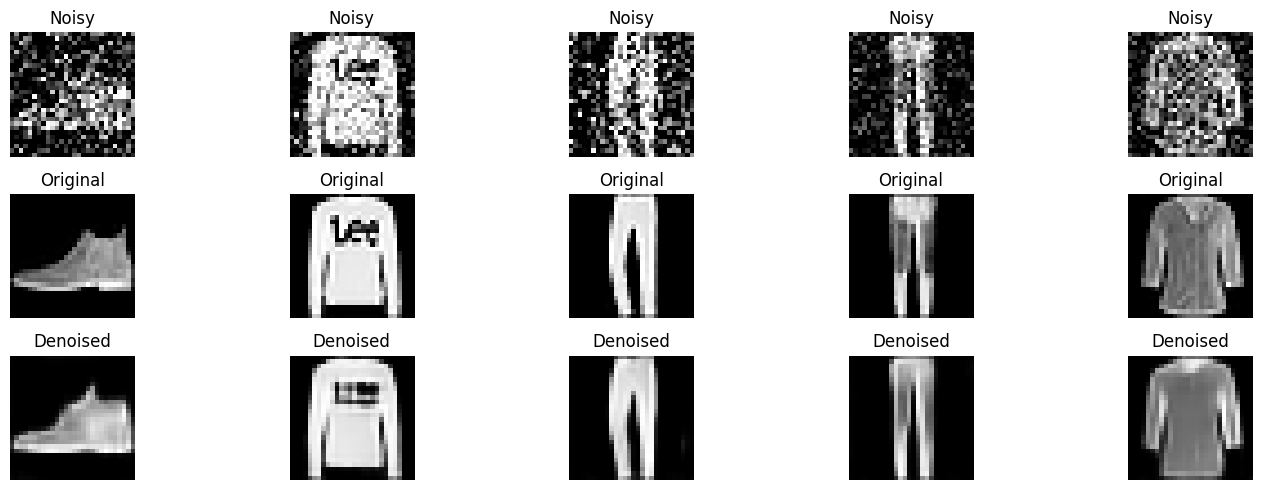

In [12]:
# Visualize original, noisy, and denoised
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(3, 5, i+6)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(3, 5, i+11)
    plt.imshow(denoised_imgs[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


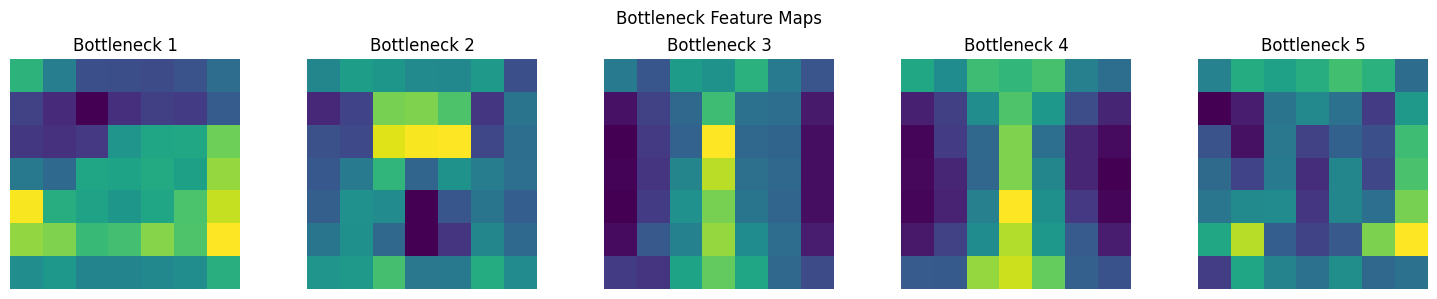

In [13]:
# Bottleneck visualization
bottleneck_features = encoder.predict(x_test[:5])
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.mean(bottleneck_features[i], axis=-1), cmap='viridis')
    plt.title(f'Bottleneck {i+1}')
    plt.axis('off')
plt.suptitle('Bottleneck Feature Maps')
plt.tight_layout()
plt.show()